# Defactoring ‘Pace of Change’

## Exploring Code Review Methods for Textual Scholarship and Literary Studies

## Introduction
Coding and code peer review are still far from generally accepted as scholarly technique and method in textual scholarship and literary studies. In this paper we argue that coding can be regarded simply as an extension of scholarly practice necessitated by the increased application of code both as a means to create digital objects as cultural artefacts and as a means of analysis within the humanities. This in turn gives rise to the question if and how such methods can be evaluated and peer reviewed. As a contribution to the exploration of methods for peer reviewing code and digital approaches to analysis we present a Jupyter Notebook that ‘defactors’ the analytic code underlying a recent publication in the field of literary studies. We then reflect on our approach and discuss how this may contribute to future development of peer reviewing methods in (digital) humanities.
Abstract

We start from the assertion that coding and code—as the source code of computer programs that is readable to humans and which drives the performative nature of software (Ford 2015, Hiller 2015)—can be inherent parts of scholarship or scholarship by and of themselves. That is: we assert that code can be scholarly, that coding can be scholarship, and that there is little difference between the authorship of code or text (Van Zundert 2016). The dichotomy that has been often sought between on the one hand a ‘pure’ intellectual realm associated with scholarly writing and academic print publication, and on the other hand the ‘material labour’ associated with for instance instrument making or programing, is artificial. 

We argue the validity of this assertion along Burgess and Hamming (2011) and Clement (2016). These scholars refer to earlier work in which Bruno Latour (1993) casts the defining characteristic of modernity as a process of ‘purification’ which aims to contrast the human culture of modernity to nature. Burgess and Hamming observe a congruent process in academia: “Within the academy we see these processes of purification and mediation at work, producing and maintaining the distinction between intellectual labor and material labor, both of which are essential to multimedia production” (Burgess & Hamming 2011:¶11). This process serves to distinguish between scholarly and non-scholarly activities: “The distinction between intellectual and material labor is pervasive throughout scholarly criticism and evaluation of media forms. […] In addition, any discussion of scholarly activities in multimedia format are usually elided in favor of literary texts, which can be safely analyzed using traditional tools of critical analysis.” However, this distinction is based upon a technological fallacy already pointed out—as Burgess and Hamming note—by Richard Grusin in 1984. Grusin argued that Hypertext has not changed the nature of text essentially, as writing has always already been hypertextual through the use of indices, notes, annotations, and intertextual references. To assume that the technology of Hypertext has unvealed or revolutionary activated the associative nature of text, amounts to the fallacy of ascribing the associative agency of cognition to the technology, which however is of course a ‘mere’ expression of that agency.

Analogous to Burgess and Hamming, we argue that relegating the evaluation of scholarship to the reviewing of print publications is an equal fallacious ascribing of agency to the technology of written text. Such a narrow understanding of scholarship presupposes that something is scholarship because it is in writing, that writing makes it scholarship. 
It is possible to evade all such possible technological fallacies by understanding scholarship as argument. We argue therefore that scholarship in essence is argument, and that technologies enable to shape and express that argument. This is not to say that technologies are mere inert and neutral epistemological tools, obviously different technologies shape and affect argument in different ways. Different technologies can therefore enrich scholarly argument. Scholarship is thus not bound to the use of text as an epistemological technology, but essentially is in the shaping of an argument. Text and writing may still be the most celebrated semiotic technologies to express an argument, but computer code understood as ‘just another’ literacy (cf. Knuth 1984, Kittler 1993, Vee 2013) can equally be the carrier of scholarly argument. 

However, the acceptance of code as another form of scholarly argument presents problems to the current scholarly process of evaluation because of a lack of well developed methods for reviewing and critiquing scholarly code. Digital humanities as a site of production of non conventional research outputs—digital editions, web based publications, new analytical method, and computational tools for instance—has spurred the debate on evaluative practices in the humanities considerably, exactly because practitioners of digital scholarship acknowledge that much of the relevant scholarship is not expressed in the form of traditional scholarly output. Yet the focus of review generally remains on “the fiction of ‘final outputs’ in digital scholarship” (Nowviskie 2011), on old form peer review (Antonijevic 2016), and on approximating equivalencies of digital content and traditional print publication (Presner 2012). Discussions around the evaluation of digital scholarship have thus “tended to focus primarily on establishing digital work as equivalent to print publications to make it count instead of considering how digital scholarship might transform knowledge practices” (Purdy & Walker 2010:178, Anderson & McPherson, 2011). As a reaction digital scholars have stressed how peer review of digital scholarship should foremost consider how digital scholarship is different from conventional scholarship. They argue that review should be focussed on the process of developing, building, and knowledge creation (Nowviskie 2011), on the contrast and overlap between the representationality of conventional scholarship and the strong performative aspects of digital scholarship (Burgess & Hamming 2011), and on the medium specificity of digital scholarship (Rockwell 2011).

The debate on peer review in digital scholarship however, has been geared much to high level evaluation, concentrating for instance on the issue how digital scholarship could be reviewed in the context of tenure track evaluations. Very little has been proposed as to concrete techniques and methods for more practical level applied peer review of program code. Existing practical guidance pertains to digital objects such as digital editions (Sahle & Vogler 2014) or to code as cultural artefact (Marino 2006), but no substantial work has been put forward on how to peer review scholarly code. We are left with the rather general statement that “traditional humanities standards need to be part of the mix, [but] the domain is too different for them to be applied without considerable adaptation” (Smithies 2012), and the often echoed contention that digital artefacts should be evaluated as such and not as to how they might have been documented in conventional articles. The latter argument probably most succinctly put by Geoffrey Rockwell (2011): “While such narratives are useful to evaluators […] they should never be a substitute for review of the work in the form it was produced in.”

Yet, the problem is growing more urgent. Increasingly, code is created and used as a mechanism of analysis in textual scholarship and literary studies—cf. for instance Enderle 2016, Jockers 2013, Piper 2015, Rybicki et al. 2014, and Underwood 2014. The algorithms, code, and software that underpins the analyses in these examples of scholarship are not standardized ‘off the shelf’ software productions. These code bases are nothing like a software package or product such as AntConc that can be viewed as a generic and packaged distributable tool; a tool that might be subject to a scholarly type of tool criticism explaining and opening it for reuse by other scholars. Instead these codebases are bespoke code: they are one-off highly specific and complex analytical engines, tailored to solving one highly specific research question based on one specific set of data. Reuse, scalability, and ease-of-use are, justifiably (Baldrigde 2015), not specific aims of these code objects at all. Such might be the case with generic software, but these programs have been algorithmic instruments tailor made to serve the research case at hand. As such—and following what was argued above—we must regard these code bases as an inherent part of the scholarly argument they contribute to. And as such they deserve and require specific and rigorous peer review, like any argument in humanities research. How such peer review should be conducted is, however, a large unknown.

As a contribution to the challenges of code peer review we present an experimental technique we call defactoring. Drawing on Braithwaite (2013), we have re-configured the program code that underpins a recent article by Ted Underwood and Jordan Sellers (Underwood & Sellers 2016) into a computational narrative—echoing Knuth’s literate programming (1984)—to be critically analyzed and annotated. This method is intimately intertwined with the Jupyter Notebook platform, which allows for the composition of scholarly and scientific inscriptions that are simultaneously human and machine readable. The Notebook is both a document format and a platform for mixing code and prose into executable objects. We have extracted Underwood and Seller’s code and defactored it into a Jupyter Notebook, available at https://github.com/interedition/paceofchange. This means we have recombined code from disparate files, linearized the execution path, demodularized function calls, and annotated code blocks with our own expository comments. As an annotated Notebook we can now engage Underwood and Seller’s code directly as a scholarly inscription and more deeply interrogate the role of data, algorithms, and code in the production of knowledge.

After demonstrating the work in the notebook, we will conclude our paper with a critical reflection of the reviewing work that was undertaken with it. We identify the applicability, feasibility, benefits, and drawbacks of this specific approach. We also outline some possible future directions of research that could further contribute to exploring review methods for code scholarship.

# How to Defactor ‘Pace of Change’

We are interested in what the process and practice looks like of 'defactoring' code. Defactoring code can be understood as close reading the source code of a particular software. This may serve multiple purposes. The process might be geared towards peer reviewing code, it may be done to understand methodological aspects and implications, it may be used as a tool to disseminate and teach such new methodologies or how to use them. Here we use the process of defactoring to produce what might be the first critical edition of any source code in the domain of digital humanities. We unpack the code that Ted Underwood wrote to do the analysis that was reported on in the article he wrote together with Jordan Sellers *How Quickly Do Literary Standards Change?* (Underwood, T. & Sellers, J., 2015. *How Quickly Do Literary Standards Change?* Available at: https://figshare.com/articles/How_Quickly_Do_Literary_Standards_Change_/1418394

The code that we are  going to defactor can be found in the Github repository where Underwood open sourced it: https://github.com/tedunderwood/paceofchange

There is no given definition of 'defactoring' or its practice. We expect there to be some agreement about the aim and purpose of the process (that can be broadly understood as attempting to understand what a particular piece of code is doing). How this process of understanding is implemented is not prescribed and may take many forms. A potential approach is simply 'using the code' in similar analytic processes, however that would not generate much insights into the actual code that in that case is treated as a black box. Backward engineering where one—in th most narrow understanding of this tactic to unpack code—tries to estimate what code is doing by comparing input and output may give some more insights. Writing automated tests that gauge the different responses to input might yet be another approach. Here however we are interested in a deep and intimate understanding of code [Frabretti 2012] to understand how it is adding or changing methodology and how it could be critiqued. For this we think meticulously deconstructing the code—which it allows us to do as it is open source—works best. 

Code is made up of instructions that are knit together in a process that may included repetition and process paths that branch out and merge back into a main process. Even fairly simple code may thus result in a 'garden of forking paths' that allows for a combinatorial explosion of possible paths that could be walked. It would require a book-sized examination to do full justice to the code and all its possible execution pathways. Even though Underwood's code is not even particular long in comparison to other code bases, there are multiple potential pathways and various choices as to what data to use, liek rivers and tributaries of data and computation. To fully realize defactoring as a critical method possibly means to explicate all possible routes through some code base. This is certainly infeasble within the scope of this article. It would also require considerable computational hardware and assistance. 

Thus it is infeasible to represent here *all* execution paths, let alone deeply inspecting them. We chose therefore to deconstruct so that we follow 1 possible execution path through Underwood and Sellers' code that we think presents a good trade off between getting to know the code and actually being able to finish deconstructing it. 

In technical terms the deconstruction that is presented here is a refactoring of Underwood and Sellers' code so that it can be represented as a single computational list of computing instructions, on in one namespace. Underwood and Sellers purposely divided their code into logical and meaningfull parts, modules, and functions that work together. For a code author this is a means of understanding, keeping track, and controling the process of creating and executing an analysis. We found however that to gain insight in how the code works and especially to narrate and disseminate its working it is useful to refactor the code into what is usually understood as a poor coding practice, namely making it all one single long strongly integrated process. This makes the code resemble more of a linear narrative. We may have stumbled here on a difference between the nature of code and text, or the relative mutual excluding of forms of representation that are in one form, divided and branched, useful to a software developer (to organize a process of analysis), and in another form, linear and narrative, more useful for a human interpreter. What we observed also is that the process of deconstruction literature and code are not symetrical but mirrored. Where deconstruction of literature usually involves it being taking apart into its various components, meanings, and contetualizations, we found that deconstructing softare by defactoring means to get an understanding of the code, its functioning, and meaning by integrating its different and disaparate parts into one single linear computational narrative. Able and 'good practices' informed code, in other words seems already deconstructed (or 'refactored') into modules and composable parts. Underwood and Sellers in this manner deconstructed the problem of analyzing poems with the specific methodology they envisioned. For all practical purposes we effectively are turning well articulated code into sub-optimal code full of 'hacks' and 'code smells'. However, we do think this leverages our ability to understand the narrative that the code also is.

We found it useful to intersperes the various logial parts of the code, those parts that seem to handle a clearly bounded 'step' in the algorithmic process, with narrative that reports on how we understood the code and its functioning at that moment of deconstruction. The Jupyter Notebook is a good fit for presenting this exploration of the code. It allows us to present a fully functioning (executable) code path, divided into steps that can be read and commented by us. Reading (and executing along the way) this notebook therefore gives the reader a close resembling of the experience of how we as deconstructionists 'close read' the code.

To support ourselves in the reading process (and hopefully also the reader now) we found it useful to keep track of the 'state' of the code as it was executing. We implemented this by listing all the 'active' variables and there values at each step of the process. The explanation of each step is therefore also ammended with a listing of these variables. 

Integrating code parts that were purposefully decoupled is not without risk of introducing bugs and cripling the code. For instance, if there are two variables with the same name but different function in two distinct codeparts, putting these code parts into one computational narrative will result in these variables conflicting, possibly overwriting one with the other with uncertain results or broken code as a consequence. Luckily the code of Underwood and Sellers was of such composition that we did not run into these kind of troubles and where potential conflict occured it was easy enough to counter it by renaming variables or introducing little bits of helper code that do not change the general signature of the code. We have altered the code written by Underwood and Sellers. The letter is changed in some places, but we contend that the spirit of the work is the same. 

Remark that the changes and additions we introduced to the code indeed are interpretations and emandations of the code: they are critical interventions just like a textual scholar would undertake, for instance, when critically editing and interpreting a historic text. We do indeed think that the Jupyter Notebook (or rather its content) that is the result of our close examination of Underwood's and Seller's code can be considered the first 'critical edition' of a codebase within the digital humanities. As with firsts, we do realize that our method is probably imperfect and susceptible to many improvements. That however is exactly the purpose of our work here: to explore the valuable and feasible forms of code criticism and its epistemic role in the humanities. [TODO: this needs some STS facing additions too.]

## What is *Defactoring*

*Defactoring* is a process or possible a tool for "[opening the black box](https://en.wikipedia.org/wiki/Blackboxing)" of computational and data intensive scholarship. It is similar to the process of *[refactoring](https://en.wikipedia.org/wiki/Code_refactoring)* in that we are "restructuring existing computing code without changing its external behavior." Typically, refactoring takes code and bundles it into a separate structure, such as a function or module, to make it more reusable and recombinable. Our efforts here have done just the opposite. We have taken code that was broken up over several functions and files and pulled it into a single, linear narrative. This process invokes *deconstructive* analytic in which we have *internally* vivisected Underwood and Sellers' code, but externally there is little change to the behavior or outputs. These reconfigurations enable us to unpack, drill-down, and dig into the code within the same platform we use to write about the code.

Defactoring, as a method of analysis, is deeply imbricated with a technical platform (just as Underwood & Sellers' data, code, and analysis are as well). But rather than pushing the code into a distant repository separate from the prosaic narrative, we compose a *[computational narrative](http://blog.jupyter.org/2015/07/07/project-jupyter-computational-narratives-as-the-engine-of-collaborative-data-science/)* whereby the data, code, and expository text are bundled together. This means we have created a document that can be read by both humans and machines. 

Such a feat is made possible by the [Jupyter Notebook](http://jupyter.com). The particular [affordances](https://en.wikipedia.org/wiki/Affordance) of the Notebook allow us to weave code, data, and prose together into a single narrative that is simultaneously readable and executable. Given our purpose, to develop a method for critically engaging the code of computational scholarship, it is imperative to foreground Underwood & Sellers' code and Notebooks *afford* a technical mechanism for doing just that.

### So what did we do?

At a practical level, we have *forked* code from the [git repository](https://github.com/tedunderwood/paceofchange) to create a new *branch* containing this Notebook you are reading now. 

Underwood and Sellers' have crafted their code such that it relatively easy to replicate their results by simply running a single command. One of the first tasks was to look at the code and follow the path of execution from that initial command. In reading through the code (as contained in multiple `.py` files) we could piece together a rough idea of how Underwood and Sellers' performed their data preparation, normalization, and analysis. However, `.py` files leave much to be desired when it comes to readability and annotateablility. 

We then copied python code from the various files in the repository into a Jupyter Notebook. Not all of the code in the repository was copied into the notebook for three main reasons. First, not all of the code included in the files is actually needed to replicate the analysis process. The repository includes a bunch of extra code, one could call it "cruft", from exploratory analysis or earlier iterations of the analytical process. For example, the file `SonicScrewdiver.py` is never called upon although, based upon the name, we might hypothesize it is an important, catch-all, modules for a variety of different tasks. Other sections of the code, are valid code, but function calls are commented out (such as `binormal_select`) and never executed. We have opted not to include these unused functions or code blocks. Second, not all of the possible execution paths are being analyzed in this Notebook. There six allowable options for slicing the data in `replicate.py`, the entry-point for re-running the analysis. We opted to follow the default, "full", which will model the entire dataset. Third, there is a large amount of code that is part of third party libraries, such as the logistic regression implementation that is part of `scikit-learn`, for a multitude of reasons (including practicality) we have decided to "step over", and not copy third-party code into this notebook. When trying to follow the path of execution for any program one needs to recognize it is "[turtles all the way down](https://en.wikipedia.org/wiki/Turtles_all_the_way_down)." To make our task possible, we have to make a decision about how far down the path of execution the defactoring process will go. We make a decision to focus only on the code written by Underwood and Sellers and leave an analysis of subsequent third-party libraries to a later, and more ambitious, defactoring effort.

![Defactoring code from python files to the notebook](notebook_resources/defactoring.png)

Underwood and Seller's code is stored within four files, `replicate.py`, `parallel_crossvalidate.py`, `metafilter.py`, and `modlingprocess.py`. Through the process of *defactoring* we have copied|move|transferred|imported code from text files to a Jupyter Notebook. This process has transformed the flow of the code, but not the outputs. 

In order for the code to execute seamlessly within the notebook, we had to make minor changes and tweaks to the code. These changes fall into 5 categories:

* *defactoring functions* - This is the most significant of the changes. When we defactor a function we take the function's code and move it to the global namespace. This has the effect of elimiating the function and just making it part of the main execution path. 
* *defactoring function calls* - When a function has been defactored, it can no longer be called since there is no explicit definitional code.
* *defactoring definitions* - Not all functions can be fully defactored. Functions that are called more than once or those that are short have been kept as re-usable functions. Defactoring Definition cells define the functions above the code cells that use them (preventing errors).
* *defactoring namespace* - Because we have defactored some of the functions and their function calls some of the variables in the namespace need to be mapped to eachother. This happens we the return value of a defactored function needs to be stored in a differently named variable.
* *defactoring inspections* - When we want to inspect the state of the process, we insert an inspection cell that prints the values of the variables of interest.
* *defactoring import* - Because the code is reliant upon external and third party functions, we need to import that code into the global namespace. This cell contains all of those imports.


One of the advantages to defactoring a function is it affords us the ability to insert critical commentary (in the form of markdown cells) into the code constituting the function itself. An unfortunate side-effect is that this makes keeping track of one's place in the code a bit difficult. 

The code expressed below has nine steps:
* [Setting Parameters](#Setting-Parameters) - Specifies parameters for the loading, cleaning, and labeling of data as well as sets conditions for the logistic regression.
* [Preparing Metadata](#Preparing-MetaData) - Generates a list of *.tsv files from the `poems/` directory. 
    * [Cleaning Metadata](#Cleaning-Metadata) - Loads the metadata file, `poemetadata.csv` and performs some cleaning of the metadata to make labeling easier.
    * [Sorting Data](#Sorting-Data) - Sort the volumes into two bins, reviewed and not reviewed using the cleaned metadata.
* [Transforming Words into Features](#Transforming-Words-into-Features) - Identifies the 3,200 most common words in the corpus. Those most common words will be the features for the regression.
    * [Filtering Authors](#Filtering-Authors) - Removes poems by authors who have been reviewed.
    * [Filtering Words](#Filtering-Words) - Remove any words from the poem data that are not in the most-common feature list.
* [Training Predictive Models](#Training-Predictive-Models) - Run a separate logistic regression for each volume, using a single volume as held-out data and measure each model's predictive power.
* [Modeling Coefficients](#Modeling-Coefficients) - Run a single logistic regression over all the data to inspect the salient coefficients.
* [Saving Output](#Saving-Output) - Save the results of the predictions and the coefficents to disk as CSV files.
* [Plotting Results](#Plotting Results) - Generate a plot showing the accuracy of the predictive models.



## Looking at the data


Before we dive into the code, we had a question about "what do they mean by *volume*?" in the Pace of Change article.

The answer, to be confirmed, lives in the [Understanding Genre in a Collection of a Million Volumes](https://figshare.com/articles/Understanding_Genre_in_a_Collection_of_a_Million_Volumes_Interim_Report/1281251). Basically, the idea of "volume" comes from the Hathi Trust.



Volume is equivalent to book. Volume is the Hathi Trust unit. 

> We worked with HathiTrust, which contains the aggregated collections of large public and university libraries; in the period we’re considering (1820-1919), that gave us a collection of roughly 758,400 books in English, of which about 53,200 include significant amounts of poetry. This doesn’t exhaustively cover print culture; it’s still a sample, with particular selection biases. (page 5)

It would seem the 53,200 number comes from the fact that Ted has page level genre information. The details of this can be found in an additional figshare repository, [Page-leve genre metadata](https://figshare.com/articles/Page_Level_Genre_Metadata_for_English_Language_Volumes_in_HathiTrust_1700_1922/1279201) where:

> Volumes of pentry often include proce introduction, or front and back matter; this was trimmed using publicly-available metadata. (page 33)

This is how he was able to extract individual poems from the Hathi Trust data.

TODO: We are going to need to be a bit more formal about how we represent the processes that created the data used in this code.

Joris and Matt had short discussion the potential for confounds in the *random* sample which might have skewed that sample because it had the potential to include reviewed poetry. Pages 33 and 34 for the Pace of Change talk about the sampling and data preparation. We needed to talk through exactly what they did to understand it fully. After our discussion we agreed with their reasoning, but we would have liked to see a few more numbers. For example, 

> when a stray volume from the random set turns up near the top of our model’s list of books likely to be reviewed, it does turn out that many of those authors are reasonably well-known (Rupert Brooke, Elaine Goodale Eastman). (page 33)

We would like to see more supporting data about the ratio between well-known and not-well-known authors popping up at the top of the model's list of books. Perhaps this is splitting hairs, but it would be good to have this supporting data. This however raises the question about how to formalize the "well-knownness" of a particular author. This utlimately might be more of a commentary upon our total ignorance of 19th century poetry, Matt and Joris are not English literary scholars (Joris is a Dutch literary scholar) and as such neither of us know very much about 19th century poets. Basically, we don't know much about Rupert Brooke and Elaine Goodale Eastman. This is perhaps a minor nitpick.

Our question is "How many *well-known* authors were in the random sample?"

## Looking at the shape of the data

The poems live in the `poems` directory. We extracted the first 20 lines of the file "dul1.ark+=13960=t5fb5xg2z.poe.tsv" to give a feel what they look like. Basically they represent the vocabulary frequency lists of each poem:

In [1]:
!head -n20 poems/dul1.ark+\=13960\=t5fb5xg2z.poe.tsv

,	2745
the	1445
and	1182
.	672
of	468
to	442
:	386
in	384
;	324
a	253
but	228
his	223
he	218
|'s|	211
with	198
—	197
that	188
on	187
they	172
for	171


So what we see are the token (not just word, but punctuation too) frequences for the volume. For this particular document, there are 2,745 commas, 1445 instances of the word `the`, and 1182 instances of the word `and`. 

In addition to data in the files in the `poems/` directory, there is a file, `poemeta.csv` that stores the metadata about each of the volumes. We can look at the first two lines of that file to see the headers and the first row of the data to see what the data points look like.

In [2]:
!head -n2 poemeta.csv

docid,actualdate,inferreddate,firstpub,recept,recordid,OCLC,author,imprint,enumcron,title,pubrev,judge,impaud,yrrev,pubname,birth,gender,nationality,othername,notes,canon
loc.ark+=13960=t8sb4zz1q,1921,1921,1921,addcanon,537314,,"Lawrence, D. H.",New York;T. Seltzer;1921.,,Tortoises,,,,,,1885,m,uk,,,y


This is the list of column headers of the metadata file, we can infer what they mean based upon their title, but there is no data dictionary to explicitly describe what these headers mean.

## Diving into the Code

We know that `replicate.py` will be our main entry-point for this analysis because the README tells us to replicate the analysis we should run the command:

> python3 replicate.py full

What we will do below is copy the code from `replicate.py` into this notebook.

In [3]:
### DEFACTORING IMPORT
import os
import csv 
import random 
from collections import Counter 
import numpy as np 
import pandas as pd 

from multiprocessing import Pool 
import matplotlib.pyplot as plt 
%matplotlib inline

*Note to the reader. If you see a red warning box don't fret, this is a by-product of our effort to Dockerize this analysis. Hopefully this will someday go away.*

### Setting Parameters

So this is not exact copy of replicate.py, instead we have *defactored* the code by starting at the branch point at line 45 of replicate.py (git commit e2b5b8f9a86d3f80360865a6628488619f7849d6). Basically everything after `if command == 'full':` and before `elif command == 'quarters':` 

MJ: The 'rest' of this module basically splits of 6 branches of the process related to the six possible ways of carving up the data `{"full", "quarters", "nations", "genders", "canon", "halves"}`, each option sets the different paramaters for the analytic process associated with that specific command. 

For reasons of feasibility we will only examine the first branching off tied to the command 'full'.
'Full' means: 
> process all 700 volumes model represented in Fig. 1 of the article 

(cf. "model the full 700-volume dataset using default settings" above)

In [4]:
## PATHS.

sourcefolder = 'poems/'
extension = '.poe.tsv'
classpath = 'poemeta.csv'
outputpath = 'mainmodelpredictions.csv'

## EXCLUSIONS.

excludeif = dict()
excludeif['pubname'] = 'TEM'
# We're not using reviews from Tait's.

excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.

excludeifnot = dict()
excludeabove = dict()
excludebelow = dict()

excludebelow['firstpub'] = 1700
excludeabove['firstpub'] = 1950
sizecap = 360

# For more historically-interesting kinds of questions, we can limit the part
# of the dataset that gets TRAINED on, while permitting the whole dataset to
# be PREDICTED. (Note that we always exclude authors from their own training
# set; this is in addition to that.) The variables futurethreshold and
# pastthreshold set the chronological limits of the training set, inclusive
# of the threshold itself.

## THRESHOLDS

futurethreshold = 1925
pastthreshold = 1800

# CLASSIFY CONDITIONS

positive_class = 'rev'
category2sorton = 'reviewed'
datetype = 'firstpub'
numfeatures = 3200
regularization = .00007


paths = (sourcefolder, extension, classpath, outputpath)
exclusions = (excludeif, 
              excludeifnot, 
              excludebelow, 
              excludeabove, 
              sizecap)
thresholds = (pastthreshold, 
              futurethreshold)
classifyconditions = (category2sorton, 
                      positive_class, 
                      datetype, 
                      numfeatures, 
                      regularization)

### DEFACTORING FUNCTION CALL
### rawaccuracy, allvolumes, coefficientuples = pc.create_model(paths, exclusions, thresholds, classifyconditions)

The code cell above is the specification of a bunch of parameters. These parameters are a set of buttons and knobs which are used to tweak the performance and execution of the computational modeling process. For example, an important variable in the cell above is `regularization` since it specifies the regularization parameter for the logistic regression. What is not well documented here, is why the value .00007 was chosen over other values. 

The last line in the code cell above, which we have documented with the comment `DEFACTORING FUNCTION CALL` is the point in replicate.py where the script calls out to a function, `create_model()` in a separate file, `parallel_crossvalidate.py`. As part of the defactoring method we draw in the `create_model()` function to incorporate it into our computational narrative.

In [5]:
### DEFACTORING INSPECTION
### what are the values being passed to create_model
print(paths)
print(exclusions)
print(thresholds)
print(classifyconditions)

('poems/', '.poe.tsv', 'poemeta.csv', 'mainmodelpredictions.csv')
({'recept': 'addcanon', 'pubname': 'TEM'}, {}, {'firstpub': 1700}, {'firstpub': 1950}, 360)
(1800, 1925)
('reviewed', 'rev', 'firstpub', 3200, 7e-05)


### Preparing Metadata

The code below captures the `create_model()` function, which does computational work that we don't want to *step over* because it is the documentation of Underwood and Seller's analysis. We don't want to treat it as a black box, we want to open it up. So the code cells below *step into* the function and explore its contents in the notebook's global namespace.

What is important to recognize about this block of code is that it is only executed once (in our tracing of an execution path), so its decomposition from a function and into the notebook doesn't cause problems with execution. There will be other functions in the narrative below that cannot be fully defactored, because they are repeatedly executed or are part of other python libraries not written by Underwood and Sellers. Those written by Underwood and Sellers are documented in the notebook and those part of other libraries are imported but remain undocumented.

Given the size and complexity of the `create_model()` function, the code has broken up over a series of cells to allow for critical discussion of the computational work being executed.

In [6]:
### DEFACTORING FUNCTION
### def create_model(paths, exclusions, thresholds, classifyconditions):
''' This is the main function in the module.
It can be called externally; it's also called
if the module is run directly.
'''
verbose = False

if not sourcefolder.endswith('/'):
    sourcefolder = sourcefolder + '/'

# This just makes things easier.

# Get a list of files.
allthefiles = os.listdir(sourcefolder)
# random.shuffle(allthefiles)

volumeIDs = list()
volumepaths = list()

for filename in allthefiles:

    if filename.endswith(extension):
        volID = filename.replace(extension, "")
        # The volume ID is basically the filename minus its extension.
        # Extensions are likely to be long enough that there is little
        # danger of accidental occurrence inside a filename. E.g.
        # '.fic.tsv'
        path = sourcefolder + filename
        volumeIDs.append(volID)
        volumepaths.append(path)
        
### DEFACTORING FUNCTION CALL
### metadict = metafilter.get_metadata(classpath, volumeIDs, excludeif, excludeifnot, excludebelow, excludeabove)

This code assembles a list of volume identifiers (`volumeIDs`) and file paths (`volumepaths`) by readings the directory listing of files in the `poems/` directory (`sourcefolder`). 

In [7]:
### DEFACTORING INSPECTION
### what are the values of the variables being passed to get_metadata()
### TODO: write a function that when given a list of variables, prints out their name & values
print(classpath)
print(volumeIDs[0:10]) # this is a long list so only showing the first 10 values
print(excludeif)
print(excludeifnot)
print(excludebelow)
print(excludeabove)

poemeta.csv
['dul1.ark+=13960=t5fb5xg2z', 'dul1.ark+=13960=t75t4h116', 'dul1.ark+=13960=t84j19z0d', 'ellisbell1848', 'emilydickinson', 'gerardmhopkins1918', 'hardywessexpoems1898', 'hvd.32044010164861', 'hvd.32044018706432', 'hvd.32044020453569']
{'recept': 'addcanon', 'pubname': 'TEM'}
{}
{'firstpub': 1700}
{'firstpub': 1950}


#### Cleaning Metadata

Before we can fully dive into the code contents of the `get_metadata()` function, we need to define a couple helper functions. These small functions perform some minor data transformations that are repeatedly used in the `get_metadata()` block.

In [8]:
### DEFACTORING FUNCTION DEFINITION
### we need these helper functions for execute the next code cell

def dirty_pairtree(htid):
    period = htid.find('.')
    prefix = htid[0:period]
    postfix = htid[(period+1): ]
    if '=' in postfix:
        postfix = postfix.replace('+',':')
        postfix = postfix.replace('=','/')
    dirtyname = prefix + "." + postfix
    return dirtyname

def forceint(astring):
    try:
        intval = int(astring)
    except:
        intval = 0

    return intval

The following is a long block of code that is difficult to break apart because of the `with open` block of code. 

In [9]:
### DEFACTORING FUNCTION 
### def get_metadata(classpath, volumeIDs, excludeif, excludeifnot, excludebelow, excludeabove):
'''
As the name would imply, this gets metadata matching a given set of volume
IDs. It returns a dictionary containing only those volumes that were present
both in metadata and in the data folder.

It also accepts four dictionaries containing criteria that will exclude volumes
from the modeling process.
'''
print(classpath)
metadict = dict()

with open(classpath, encoding = 'utf-8') as f:
    reader = csv.DictReader(f)

    anonctr = 0

    for row in reader:
        volid = dirty_pairtree(row['docid'])
        theclass = row['recept'].strip()

        # I've put 'remove' in the reception column for certain
        # things that are anomalous.
        if theclass == 'remove':
            continue

        bail = False
        for key, value in excludeif.items():
            if row[key] == value:
                bail = True
        for key, value in excludeifnot.items():
            if row[key] != value:
                bail = True
        for key, value in excludebelow.items():
            if forceint(row[key]) < value:
                bail = True
        for key, value in excludeabove.items():
            if forceint(row[key]) > value:
                bail = True

        if bail:
            print("tossing "+volid) ## DEFACTORING CODE
            continue

        birthdate = forceint(row['birth'])

        pubdate = forceint(row['inferreddate'])

        gender = row['gender'].rstrip()
        nation = row['nationality'].rstrip()

        #if pubdate >= 1880:
            #continue

        if nation == 'ca':
            nation = 'us'
        elif nation == 'ir':
            nation = 'uk'
        # I hope none of my Canadian or Irish friends notice this.

        notes = row['notes'].lower()
        author = row['author']
        if len(author) < 1 or author == '<blank>':
            author = "anonymous" + str(anonctr)
            anonctr += 1

        title = row['title']
        canon = row['canon']

        # I'm creating two distinct columns to indicate kinds of
        # literary distinction. The reviewed column is based purely
        # on the question of whether this work was in fact in our
        # sample of contemporaneous reviews. The obscure column incorporates
        # information from post-hoc biographies, which trumps
        # the question of reviewing when they conflict.

        if theclass == 'random':
            obscure = 'obscure'
            reviewed = 'not'
        elif theclass == 'reviewed':
            obscure = 'known'
            reviewed = 'rev'
        elif theclass == 'addcanon':
            print("this is executing") ## DEFACTORING CODE
            obscure = 'known'
            reviewed = 'addedbecausecanon'
        else:
            print("Missing class" + theclass)

        if notes == 'well-known':
            obscure = 'known'
        if notes == 'obscure':
            obscure = 'obscure'

        if canon == 'y':
            if theclass == 'addcanon':
                actually = 'Norton, added'
            else:
                actually = 'Norton, in-set'
        elif reviewed == 'rev':
            actually = 'reviewed'
        else:
            actually = 'random'

        metadict[volid] = dict()
        metadict[volid]['reviewed'] = reviewed
        metadict[volid]['obscure'] = obscure
        metadict[volid]['pubdate'] = pubdate
        metadict[volid]['birthdate'] = birthdate
        metadict[volid]['gender'] = gender
        metadict[volid]['nation'] = nation
        metadict[volid]['author'] = author
        metadict[volid]['title'] = title
        metadict[volid]['canonicity'] = actually
        metadict[volid]['pubname'] = row['pubname']
        metadict[volid]['firstpub'] = forceint(row['firstpub'])

# These come in as dirty pairtree; we need to make them clean.

cleanmetadict = dict()
allidsinmeta = set([x for x in metadict.keys()])
allidsindir = set([dirty_pairtree(x) for x in volumeIDs])
missinginmeta = len(allidsindir - allidsinmeta)
missingindir = len(allidsinmeta - allidsindir)
print("We have " 
      + str(missinginmeta) 
      + " volumes in missing in metadata, and")
print(str(missingindir) + " volumes missing in the directory.")
print(allidsinmeta - allidsindir)

for anid in volumeIDs:
    dirtyid = dirty_pairtree(anid)
    if dirtyid in metadict:
        cleanmetadict[anid] = metadict[dirtyid]

### DEFACTORING FUNCTION RETURN
### return cleanmetadict               


poemeta.csv
tossing loc.ark:/13960/t8sb4zz1q
tossing mdp.39015013402501
tossing mdp.39015011913525
tossing hardywessexpoems189.hardywessexpoems1898
tossing gerardmhopkins191.gerardmhopkins1918
tossing loc.ark:/13960/t3fx82c2q
tossing emilydickinso.emilydickinson
tossing ellisbell184.ellisbell1848
We have 8 volumes in missing in metadata, and
0 volumes missing in the directory.
set()


In [10]:
### DEFACTORING INSPECTION
### looking up an ID listed earlier
cleanmetadict['dul1.ark+=13960=t5fb5xg2z']

{'author': 'Arnold, Matthew,',
 'birthdate': 1822,
 'canonicity': 'Norton, in-set',
 'firstpub': 1855,
 'gender': 'm',
 'nation': 'uk',
 'obscure': 'known',
 'pubdate': 1855,
 'pubname': 'ER',
 'reviewed': 'rev',
 'title': 'Poems'}

In [11]:
### DEFACTORING NAMESPACE 
metadict = cleanmetadict  # put the data into the global namespace

What just happened here? Well, the code above loaded the `poemeta.csv` file and filtered out a bunch of rows (based upon the `excludeif`, `excludeifnot`, `excludeabove`, and `excludebelow` variables) and also normalizes some of the `nation` data (normalizing is a pretty clinical way of lumping Canada with the United States and Ireland with the UK). Nationality is not a factor in the Pace of Change analysis, but it is interesting to see this code here, it implies this code is used in other analyses.

The other important thing this code cell does is split the `recept` column in the `poemeta.csv` into two columns, `obscure` and `reviewed`. There is a bit of logic here that we do not fully grasp at this point. From what we can tell from the code and Ted's comment, there poems that are reviewed, there are poems that are obscure, and there are poems that are not in the reviewed set but are never-the-less part of the cannon. This means they are "known" and, according to Ted's comment, trumps the conflict when the author is known (`obscure = 'known'`) but not explicitly in the reviewed set. 

We have discovered after adding some `# DEFACTORING CODE` snippets that this code never actually runs. All of the poems with the 'addcanon' property are tossed out and the conflict, where the poem is known by in the random set, never appears to occur. Conjector: is this a remnant of Ted refactoring the code due to changes in the analysis process or just working with different data or something we cannot possible conceive. What was the author's intent? 

We know that poems with the 'addcanon' in the 'recept' column are being excluded because they are included in the `excludeif` dictionary. Why? The code in the first code cell provides somewhat of an explanation

```
excludeif['recept'] = 'addcanon'
# We don't ordinarily include canonical volumes that were not in either sample.
# These are included only if we're testing the canon specifically.
```

It should noted we spent a considerable amount of time interpreting the code that handled this particular situation before realizing that it would never be executed because of the settings in the `excludeif` dictionary. That makes us look stupid, but we also now have a more intimate understanding and relationship with the code. or maybe we are still stupid.

In [12]:
# Now that we have a list of volumes with metadata, we can select the groups of IDs
# that we actually intend to contrast. If we want to us more or less everything,
# this may not be necessary. But in some cases we want to use randomly sampled subsets.

# The default condition here is

# category2sorton = 'reviewed'
# positive_class = 'rev'
# sizecap = 350
# A sizecap less than one means, no sizecap.

### DEFACTORING FUNCTION CALL
### IDsToUse, classdictionary = metafilter.label_classes(metadict, category2sorton, positive_class, sizecap)

#### Sorting Training Data

We have DEFACTORED the metafilter.label_classes() function. This function reads the metadata properties and puts all entries into one of two bins: *positive* or *negative*.

In [13]:
### DEFACTORING FUNCTION
### def label_classes(metadict, category2sorton, positive_class, sizecap):
''' This takes as input the metadata dictionary generated
by get_metadata. It subsets that dictionary into a
positive class and a negative class. Instances that belong
to neither class get ignored.
'''

all_instances = set([x for x in metadict.keys()])

# The first stage is to find positive instances.

all_positives = set()

for key, value in metadict.items():
    if value[category2sorton] == positive_class:
        all_positives.add(key)

This is where the author's code distinguishes the red triangles from the grey dots in figure one. If poem metadata has the value 'rev' for the 'reviewed' property then it is labeled as a positive. The next cell does the same for all negatives and removes any items that were added because of the canon.

In [14]:
all_negatives = all_instances - all_positives
iterator = list(all_negatives)
for item in iterator:
    if metadict[item]['reviewed'] == 'addedbecausecanon':
        all_negatives.remove(item)

The negative labels are assigned to all instances that are not in the set of positive instances. There is additional code that filters out anything with 'addedbecausecannon' set for the 'reviewed' property, but this code should never execute. This is a vestige of testing with the canon.

In [15]:
if sizecap > 0 and len(all_positives) > sizecap:
    positives = random.sample(all_positives, sizecap)
else:
    positives = list(all_positives)
    print(len(all_positives))

360


Because we see `360` being printed by the code above we know he is not sampling from the positives list. Ted's comment above, seems to indicate the sizecap is 350, but if you look at the code in the first code cell, the sizecap is *actually* 360...which just so happens to be the number of positive labeled instances. Funny. Looks like Ted updated his sizecap, but didn't update his comment.

How was the sizecap determined? Performance and scalability? Perhaps some of the test sets were much larger than 360 instances?

In [16]:
# If there's a sizecap we also want to ensure classes have
# matching sizes and roughly equal distributions over time.

numpositives = len(all_positives)

if sizecap > 0 and len(all_negatives) > numpositives:
    if not 'date' in category2sorton:
        available_negatives = list(all_negatives)
        negatives = list()

        for anid in positives:
            date = metadict[anid]['pubdate']

            available_negatives = sort_by_proximity(available_negatives, 
                                                    metadict, date)
            selected_id = available_negatives.pop(0)
            negatives.append(selected_id)

    else:
        # if we're dividing classes by date, we obvs don't want to
        # ensure equal distributions over time.

        negatives = random.sample(all_negatives, sizecap)

else:
    negatives = list(all_negatives)

So most of the code in the cell above does not execute because we are not sampling from the positives distribution. 

This code cell makes an un-excuted reference to a function `sort_by_proximity()` which we are not including because it is not part of the execution path we are documenting in this notebook. This has provoked a conversation about if we should remove the code from the conditional blocks from the notebook. Yet, keeping them maintains the residue of Ted's development and thinking about what he needs to do with the data and in the analysis. 

These issues point to properties of code that make it difficult to review or critique, that is, we are in this case, reviewing a single execution path of the code, not the code itself. So we are dealing with a *code-criticism conundrum*: What is the required or adequate breadth and depth of the critique? The decision to include or not include `sort_by_proximity()` is a breadth issue. How broad should we be in including code that does not execute? Note, we are including code from a conditional block that doesn't execute, but are not going out the additional step to include non-executed function defined elsewhere in the code. The decision to include or not include code from the standard library, code not written by Ted, is a depth issue. In the code cell above, there are many functions we are *stepping over*, like `len`, `list`, `append`, `pop`, `random.sample`, etc., because they are black-boxed. There is no need to critique or test or inspect those functions because they have been tested and evaluated  thoroughly outside of the scope of Ted's project [We need a strong REF here].

Full reflexivity here would also mean that we note that the 'rules of the game' for code criticism aren't quite clear yet and therefore we are possibly feeling our way through an emerging methodological standard of practice for code criticism. As we see vestiges of Ted evolution in thinking in his code, this notebook is capturing the evolution of our thinking about DEFACTORING as a practice. 

REF: Hiller and Joris about the tension between code's textual and processual dimensions.


In [17]:
# Now we have two lists of ids.

IDsToUse = set()
classdictionary = dict()

print()
print("We have " + str(len(positives)) + " positive, and")
print(str(len(negatives)) + " negative instances.")

for anid in positives:
    IDsToUse.add(anid)
    classdictionary[anid] = 1

for anid in negatives:
    IDsToUse.add(anid)
    classdictionary[anid] = 0

for key, value in metadict.items():
    if value['reviewed'] == 'addedbecausecanon':
        IDsToUse.add(key)
        classdictionary[key] = 0
# We add the canon supplement, but don't train on it.

### DEFACTORING FUNCTION RETERN
### return IDsToUse, classdictionary


We have 360 positive, and
360 negative instances.


### Transforming Words into Features


Now we return to the execution of the `create_model` function from `parallel_crossvalidate.py`

In [18]:
### DEFACTORING FUNCTION DEFINITIONS
### We need to define the infer_date function

def infer_date(metadictentry, datetype):
    if datetype == 'pubdate':
        return metadictentry[datetype]
    elif datetype == 'firstpub':
        firstpub = metadictentry['firstpub']
        if firstpub > 1700 and firstpub < 1950:
            return firstpub
        else:
            return metadictentry['pubdate']
    else:
        sys.exit(0)

In [19]:
# make a vocabulary list and a volsize dict
wordcounts = Counter()

volspresent = list()
orderedIDs = list()

positivecounts = dict()
negativecounts = dict()

for volid, volpath in zip(volumeIDs, volumepaths):
    if volid not in IDsToUse:
        continue
    else:
        volspresent.append((volid, volpath))
        orderedIDs.append(volid)

    date = infer_date(metadict[volid], datetype)
    if date < pastthreshold or date > futurethreshold:
        continue
    else:
        with open(volpath, encoding = 'utf-8') as f:
            for line in f:
                fields = line.strip().split('\t')
                if len(fields) > 2 or len(fields) < 2:
                    # print(line)
                    continue
                word = fields[0]
                if len(word) > 0 and word[0].isalpha():
                    count = int(fields[1])
                    wordcounts[word] += 1
                    # for initial feature selection we use the number of
                    # *documents* that contain a given word,
                    # so it's just +=1.

vocablist = [x[0] for x in wordcounts.most_common(numfeatures)]

# vocablist = binormal_select(vocablist, positivecounts, negativecounts, totalposvols, totalnegvols, 3000)
# Feature selection is deprecated. There are cool things
# we could do with feature selection,
# but they'd improve accuracy by 1% at the cost of complicating our explanatory task.
# The tradeoff isn't worth it. Explanation is more important.
# So we just take the most common words (by number of documents containing them)
# in the whole corpus. Technically, I suppose, we could crossvalidate that as well,
# but *eyeroll*.

In [20]:
### DEFACTORING INSPECTION
### What is in the vocablist variable?
print(len(vocablist))
print(vocablist[0:50])

3200
['all', 'is', 'at', 'a', 'in', 'the', 'on', 'to', 'for', 'as', 'i', 'but', 'that', 'with', 'by', 'of', 'not', 'and', 'who', 'it', 'his', 'be', 'when', 'from', 'one', 'they', 'he', 'like', 'or', 'now', 'was', 'their', 'no', 'this', 'have', 'so', 'we', 'them', 'see', 'its', 'there', 'where', 'her', 'will', 'are', 'then', 'were', 'heart', 'our', 'an']


This is an important section of code because it contains the code for the selection of the 3200 word-features, or "variables" as he calls them on page 35 (the methodology appendix), used in the logistic regression. Most notable is the code that has been commented out at the very end of the block. The heuristic for feature selection was simply to select the 3200 most common words, a simple and easy to explain technique (also easy to implement with Python's Counter collection). The comment discusses an alternative feature selection technique using binormal selection which he has implemented in the function `binormal_selection`. Because this code is commented out, we do not explore it in-depth here. More interesting is the rationale about *why* it has been commented out:

> There are cool things we could do with feature selection, but they'd improve accuracy by 1% at the cost of complicating our explanatory task.

What we are seeing in this comment is a road not taken, which normally the DEFACTORING method would ignore, but the code, the comment, and the implications are crucially important. This reveals much about about Ted's reasoning on the effort and energy he wishes to invest in *explaining* method. There is judgment about the expertise of his audience. This points to a crucial problem at the intersection of humanities and computer science where the dissemination of description of statistical methods are inhibiting or hindering the full realization of the epistemlogical richness of computation as a method of inquiry. Ted is holding himself back, a form of self-censorship, because of a perceived Audience That cannot understand a binormal feature selection technique without a significant amount of work to explain its epistomolgical implications. 

We think this snippet of code is significant and justifies our method because it is only through close code review were we able to uncover these traces of Ted's thinking and experimentation. We can see epistomolary roads not taken because of strenuous dialectical relationship between the computational potentiality and the disciplinary acceptability. 

There is more for us to say and think about this vinette. But we need to move on.

Aside: we couldn't help ourselves and did a little digging into the `binormal_selection` function. There is an oblique reference to "see forman" which we think refers to George Forman who has written several articles on feature selection in texts. We should confirm with Ted.
- http://dl.acm.org/citation.cfm?id=944974
- http://link.springer.com/chapter/10.1007%2F3-540-45681-3_13
- We think this is the paper: http://www.hpl.hp.com/techreports/2007/HPL-2007-32R1.pdf



#### Filtering Authors

In [21]:
donttrainon = list()

# Here we create a list of volumed IDs not to be used for training.
# For instance, we have supplemented the dataset with volumes that
# are in the Norton but that did not actually occur in random
# sampling. We want to make predictions for these, but never use
# them for training.

for idx1, anid in enumerate(orderedIDs):
    reviewedstatus = metadict[anid]['reviewed']
    date = infer_date(metadict[anid], datetype)
    if reviewedstatus == 'addedbecausecanon':
        donttrainon.append(idx1)
    elif date < pastthreshold or date > futurethreshold:
        donttrainon.append(idx1)

authormatches = [list(donttrainon) for x in range(len(orderedIDs))]
# For every index in authormatches, identify a set of indexes that have
# the same author. Obvs, there will always be at least one.

# Since we are going to use these indexes to exclude rows, we also add
# all the ids in donttrainon to every volume

for idx1, anid in enumerate(orderedIDs):
    thisauthor = metadict[anid]['author']
    for idx2, anotherid in enumerate(orderedIDs):
        otherauthor = metadict[anotherid]['author']
        if thisauthor == otherauthor and not idx2 in authormatches[idx1]:
            authormatches[idx1].append(idx2)

for alist in authormatches:
    alist.sort(reverse = True)

# I am reversing the order of indexes so that I can delete them from
# back to front, without changing indexes yet to be deleted.
# This will become important in the modelingprocess module.

In [22]:
### DEFACTORING INSPECTION
### What volumes are we not training on?
print(donttrainon)

[]


The output is blank, what this tells us is all volumes are being used in the training. Lets inspect a few more variables.

In [23]:
### DEFACTORING INSPECTION
print(len(orderedIDs))
print(len(authormatches))
print(authormatches[7])
print(authormatches[582])
print(orderedIDs[582])
print(orderedIDs[499])
print(metadict['uc2.ark+=13960=t3fx7436h'])
print(metadict['uc1.b4104728'])

720
720
[582, 499, 420, 368, 200, 7]
[582, 499, 420, 368, 200, 7]
uc2.ark+=13960=t3fx7436h
uc1.b4104728
{'reviewed': 'rev', 'pubname': 'ER', 'birthdate': 1809, 'obscure': 'known', 'pubdate': 1861, 'gender': 'm', 'firstpub': 1849, 'canonicity': 'Norton, in-set', 'title': 'In memoriam', 'author': 'Tennyson, Alfred Tennyson,', 'nation': 'uk'}
{'reviewed': 'rev', 'pubname': 'WR', 'birthdate': 1809, 'obscure': 'known', 'pubdate': 1859, 'gender': 'm', 'firstpub': 1859, 'canonicity': 'Norton, in-set', 'title': 'Idyls of the King', 'author': 'Tennyson, Alfred Tennyson,', 'nation': 'uk'}


This is all rote data preparation. The authors compile a list that shouldn't be used as training data if the date is incorrect or if the books are part of the "addedbecauseofcanon" class (representing a well known author). From this list they compile a list of authors who have been reviewed and then removing their other works from the list. 

The inspection code above was necessary for us to understanding the complicated data structure they created.

The list `authormatches` is a list of all the poems and each is a list of other poems by the same author. Essentially this data structure is describing the relations of each poem to other poems, that relation being "other poems by the same author". It took us a bit of work to figure out because all of this is obscured by the fact the relations are expressed by list indexes. We are working with abstractions which we assume are important for the `modelingprocess` which is invoked below.

The purpose of this is because

> ...we did exclude who were already in our reviewed sample for a given genre. (page 34)

What we seen in the code is the necessary steps to be able to exclude author already in the reviewed sample, but we don't yet see any reference to genre. Either this is implicit (because all these data are the same genre, poetry) or hasn't been addressed as of yet in the code.

Aside: we should try an annotate the author's narrative in the article to point to the specific moments in the code where he is describing (in english) what is happening in the code.

#### Filtering Words

In [24]:
### DEFACTORING DEFINITIONS

usedate = False
# Leave this flag false unless you plan major
# surgery to reactivate the currently-deprecated
# option to use "date" as a predictive feature.

def get_features(wordcounts, wordlist):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    return wordvec

# In an earlier version of this script, we sometimes used
# "publication date" as a feature, to see what would happen.
# In the current version, we don't. Some of the functions
# and features remain, but they are deprecated. E.g.:

def get_features_with_date(wordcounts, wordlist, date, totalcount):
    numwords = len(wordlist)
    wordvec = np.zeros(numwords + 1)
    for idx, word in enumerate(wordlist):
        if word in wordcounts:
            wordvec[idx] = wordcounts[word]

    wordvec = wordvec / (totalcount + 0.0001)
    wordvec[numwords] = date
    return wordvec

The function `get_features` simply takes the wordcounts from the parsed poem and filters out any words that are not part of `wordlist` which is the selected features described above.

Note, we are `including get_features_with_date` even though it is not called beacuse it is part of Underwood and Seller's comment narrative above. While it is present in the code below it is never called.

In [25]:
volsizes = dict()
voldata = list()
classvector = list()

for volid, volpath in volspresent:

    with open(volpath, encoding = 'utf-8') as f:
        voldict = dict()
        totalcount = 0
        for line in f:
            fields = line.strip().split('\t')
            if len(fields) > 2 or len(fields) < 2:
                continue

            word = fields[0]
            count = int(fields[1])
            voldict[word] = count
            totalcount += count

    date = infer_date(metadict[volid], datetype)
    date = date - 1700
    if date < 0:
        date = 0

    if usedate:
        features = get_features_with_date(voldict, 
                                          vocablist, 
                                          date, 
                                          totalcount)
        voldata.append(features)
    else:
        features = get_features(voldict, vocablist)
        voldata.append(features / (totalcount + 0.001))


    volsizes[volid] = totalcount
    classflag = classdictionary[volid]
    classvector.append(classflag)

data = pd.DataFrame(voldata)

sextuplets = list()
for i, volid in enumerate(orderedIDs):
    listtoexclude = authormatches[i]
    asixtuple = (data, 
                 classvector, 
                 listtoexclude, 
                 i, 
                 usedate, 
                 regularization)
    sextuplets.append(asixtuple)

This code opens up each of the files in the poems/ directory, parses the file, does some data cleaning with respect to the structure of those files and with dates of poems older than 1700 (this is probably vestage code because we are not using date as a predictive feature. The important bit is the call to the `get_features` function which throws out the word features that are not part of the list of selected word features as determined by the `most_common()` call above and stored in the `vocablist` variable. 


We are curious about this code:

```
voldata.append(features / (totalcount + 0.001))
```

We understand he is normalizing the data to make volumes of differing sizes comparable. Turning absolute frequencies into relative frequencies. However, we don't know why he is adding 0.001 to the total count. Is this to prevent a potential divide by zero? NOTE: we think that the 0.001 is added so the logistic regression doesn't result in infinite at zero when running the cost function.

Sextuplets is a list of tuples with six values. This is the datastructure which will be passed to the modeling process. Each row of `sextuplets` contains all of the necessary data structures to model each poem. because we are generating a new model for each poem, we need to pass a couple parameters to the modeling process (such as which poems to ignore because they are by the same author, `listtoexclude`, when modeling)

#### A quick investigation of the six key datastructures

The modeling function described in the next section of the notebook relies upon six data structures from 

- data: a document features matrix. Word features are the columns and volumes are the rows. 720 x 3200
- classvector: the classification of documents as either 'reviewed' (1) or 'random' (0).
- listtoexclude: the list of poems to ignore because they are the same author
- i: the index of the volume
- usedate: a flag indicating if date is a feature. It is false in the default execution path.
- regularization: a parameter for the scikit-learn LogisticRegression function. hardcoded parameter from the beginning of the notebook.

In [26]:
### DEFACTORING INSPECTION
print(sextuplets[582][0].head()) #data
print(sextuplets[582][1]) #classvector 
print(sextuplets[582][2]) #listtoexclude
print(sextuplets[582][3]) #i
print(sextuplets[582][4]) #usedate
print(sextuplets[582][5]) #regularization


       0         1         2         3         4         5         6     \
0  0.004799  0.005708  0.002581  0.009198  0.013961  0.052534  0.006799   
1  0.004145  0.006467  0.003084  0.009484  0.013928  0.051733  0.005472   
2  0.001781  0.010095  0.006532  0.013658  0.013658  0.049881  0.002969   
3  0.001175  0.002776  0.002401  0.017079  0.008302  0.042335  0.004751   
4  0.005599  0.001786  0.003620  0.012671  0.011995  0.037674  0.005768   

       7         8         9       ...         3190      3191      3192  \
0  0.016069  0.006217  0.003417    ...     0.000036  0.000036  0.000036   
1  0.014558  0.004510  0.003349    ...     0.000033  0.000033  0.000033   
2  0.020190  0.007126  0.004157    ...     0.000000  0.000000  0.000000   
3  0.014753  0.006626  0.003351    ...     0.000225  0.000000  0.000000   
4  0.016001  0.005551  0.006372    ...     0.000048  0.000024  0.000000   

       3193      3194      3195      3196      3197      3198      3199  
0  0.000036  0.000036  0

### Training Predictive Models

We are now about to step down into the very heart of the project, the modeling of each individual text.

To do this we need to bring the function, model_one_volume into the global namespace of the notebook. This means we need to dig into a new module, modelingprocess and extract a few functions from it. The main modeling functin, `model_one_volume` depends upon two helper functions, `normalizearray()` and `sliceframe.`

In [27]:
### DEFACTORING DEFINITION

# modelingprocess.py

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

def sliceframe(dataframe, yvals, excludedrows, testrow):
    numrows = len(dataframe)
    newyvals = list(yvals)
    for i in excludedrows:
        del newyvals[i]
        # NB: This only works if we assume that excluded rows
        # has already been sorted in descending order !!!!!!!
        # otherwise indexes will slide around as you delete

    trainingset = dataframe.drop(dataframe.index[excludedrows])

    newyvals = np.array(newyvals)
    testset = dataframe.iloc[testrow]

    return trainingset, newyvals, testset

def normalizearray(featurearray, usedate):
    '''Normalizes an array by centering on means and
    scaling by standard deviations. Also returns the
    means and standard deviations for features.
    '''

    numinstances, numfeatures = featurearray.shape
    means = list()
    stdevs = list()
    lastcolumn = numfeatures - 1
    for featureidx in range(numfeatures):

        thiscolumn = featurearray.iloc[ : , featureidx]
        thismean = np.mean(thiscolumn)

        thisstdev = np.std(thiscolumn)

        if (not usedate) or featureidx != lastcolumn:
            # If we're using date we don't normalize the last column.
            means.append(thismean)
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = \
                (thiscolumn - thismean) / thisstdev
        else:
            print('FLAG')
            means.append(thismean)
            thisstdev = 0.1
            stdevs.append(thisstdev)
            featurearray.iloc[ : , featureidx] = \
                (thiscolumn - thismean) / thisstdev
            # We set a small stdev for date.

    return featurearray, means, stdevs

def model_one_volume(data5tuple):
    data, classvector, listtoexclude, i, usedate, regularization = \
        data5tuple
    trainingset, yvals, testset = sliceframe(data, 
                                             classvector, 
                                             listtoexclude, 
                                             i)
    newmodel = LogisticRegression(C = regularization)
    trainingset, means, stdevs = normalizearray(trainingset, usedate)
    newmodel.fit(trainingset, yvals)

    testset = (testset - means) / stdevs
    prediction = newmodel.predict_proba(testset.reshape(1, -1))[0][1]
    if i % 50 == 0:
        print(i)
    # print(str(i) + "  -  " + str(len(listtoexclude)))
    return prediction



What is happening here:

- iterates over every volume
- removes that volume and any other volumes by the same author from the training set
- normalizes the training set by computing the z-score for each feature/feature set
- fits the model on the z-scores
- normalizes the test data by computing the z-score
- using the fitted model, predicts the probability of the test data that it is either reviewed or random




#### sliceframe()

This function prepares the data for training a model for a specific volume. Given all of the data, all of the classifications, a list of volumes to exclude, and the index of the specific volume to model, this function removes the specific volume and the volumes by the same authors (indicated by `excluderows`) from the training data set (because we are holding out one volume to be classified by the logistic regression). This function then returns a training set, a list of classifications, and the held-out volume to-be-classified once the model has been trained. 


#### normalizearray()

This function computes the z-score for each value in the training set. That is, it loops over each each column in the data structure, subtracts the column mean from each value, and then divides that by the standard deviation. 


Question:
- Why is he normalizing the data by computing z-scores?

> In training the model we “normalize” word frequencies by the standard deviation for each word (across the whole dataset). So when we use the model to illuminate specific passages, we also divide coefficients by the standard deviation. This tells us, roughly, how much a single occurrence of a given word would affect the model’s prediction, which is what we’re trying to dramatize when we quote a passage. (page 35)


The answer appears to have something to do with using the model's coefficients in the interpretation of the effect of individual words.   


#### Logistic Regression

Our investigation into the mechanisms of logistic regression were driven by the question "what is the regularization value?"

This lead us spend some time watching [Andrew Ng explain classification using Logistic Regression](https://class.coursera.org/ml-005/lecture) on his Coursera course.

At a very high level, logistic regression is a machine learning algorithm for performing classification. Logistic regression works by estimating the parameters of a function, the *hypothesis representation*, that divides a multidimensional space into two parts (note, in this case we are talking about binomial or binary logistic regression, which classifies things into one of two bins). The hypothesis representation describes a line that winds its way through the space creating what is called the *decision boundary.* Every data point that lands on one side the boundary gets one label and every data point on the other side of the boundary gets the other label. Similar to linear regression, the goal is to find the best hypothesis representation, that is, the function that best draws a line that divides the space given your already classified data. Once you have a good hypothesis representation, and appropriately *fit* model, you can begin to classify *new* data.

The key to logistic regression is estimating the parameters of the hypothesis representation. We can derive the parameters by using the *features* of existing data combined with their already known labels; this is called *training data*. The modeling process, the function call to `newmodel.fit(trainingset, yvals)` in Ted's code above, uses training data–the matrix of poem features in the `data` variable and known labels ('reviewed' or 'random') in the `classvector` variable–to "learn" the parameters through a process called *gradient descent* (note: scikit-learn uses a different process called [*coordinate descent*](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) which is exceptionally complex). How gradient descent or the more advanced optimization functions like coordinate descent work are well beyond the scope of the discussion (and our explanatory power) so we will just nod and gesture towards the mathematical magic performed by the `newmodel.fit(trainingset, yvals)` function call.

##### Overfitting

One of the problems when fitting a logistic regression model is a tendency towards *overfitting*. Crudely this means the model, the function and set of parameters, you estimated have tailored themselves so that they are overly optimized to the data you have. As such, the model becomes less useful for *prediction* or classifying any new data you might encounter. In Ted's case, he is fitting a model based upon all of the poems and their classifications *except one (or a few by the same author)* which he then uses to predict if the *held out* poem was 'reviewed' or 'random.' If he *overfits* the model, it will to a terrible job guessing the status of the held out poem. 

Regularization is a technique for logistic regression (and other machine learning algorithms) which helps smooth out the tendency toward overfitting with some more mathematical gymnastics that we don't quite have the power to explain with word, but we can explain visually. The diagram below shows how regularization can help with the fitness of the model.

![Regularization](notebook_resources/regression_figures.png)

*On the left side is a linear regression which doesn't quite fit the data. In the middle is an overfit logistic regression. On right side is a regularized logistic regression.*

As the diagrams show, the regularized logistic expression (the right side) does have a bit of error, there are pink and blue dots on the wrong sides of the decision boundary, but as more data get added it will generally be more right than the overfitted model as represented by the middle diagram (the squiggly decision boundary). 

The LinearRegression function of the scikit-learn library allows users to specify a regularization parameter when instantiating a model (`newmodel = LogisticRegression(C = regularization)` in Underwood and Seller's code). They have set the `regularization` parameter to 0.00007. Our question is *why?*

#### Running the Regression

The code cell below is the scaffolding code that runs the modeling function. This code cell takes a long time to execute, it is training a new model for each book. It uses Python's built in parallel processing modules (`Pool(processes = 4)`) to speed up the process.

In [28]:
# Now do leave-one-out predictions.
print('Beginning multiprocessing.')

pool = Pool(processes = 4)
res = pool.map_async(model_one_volume, sextuplets)

# After all files are processed, write metadata, errorlog, and counts of phrases.
res.wait()
resultlist = res.get()

assert len(resultlist) == len(orderedIDs)

logisticpredictions = dict()
for i, volid in enumerate(orderedIDs):
    logisticpredictions[volid] = resultlist[i]

pool.close()
pool.join()

print('Multiprocessing concluded.')

Beginning multiprocessing.
0
50
100
150
200
250
300
350
450
500
400
550
600
650
700
Multiprocessing concluded.


TODO: some commentary here

In [29]:
truepositives = 0
truenegatives = 0
falsepositives = 0
falsenegatives = 0
allvolumes = list()

with open(outputpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    header = ['volid', 
              'reviewed', 
              'obscure', 
              'pubdate', 
              'birthdate', 
              'gender', 
              'nation', 
              'allwords', 
              'logistic', 
              'author', 
              'title', 
              'pubname', 
              'actually', 
              'realclass']
    writer.writerow(header)
    for volid in IDsToUse:
        metadata = metadict[volid]
        reviewed = metadata['reviewed']
        obscure = metadata['obscure']
        pubdate = infer_date(metadata, datetype)
        birthdate = metadata['birthdate']
        gender = metadata['gender']
        nation = metadata['nation']
        author = metadata['author']
        title = metadata['title']
        canonicity = metadata['canonicity']
        pubname = metadata['pubname']
        allwords = volsizes[volid]
        logistic = logisticpredictions[volid]
        realclass = classdictionary[volid]
        outrow = [volid, 
                  reviewed, 
                  obscure, 
                  pubdate,
                  birthdate, 
                  gender, 
                  nation, 
                  allwords, 
                  logistic, 
                  author, 
                  title, 
                  pubname, 
                  canonicity, 
                  realclass]
        writer.writerow(outrow)
        allvolumes.append(outrow)

        if logistic > 0.5 and classdictionary[volid] > 0.5:
            truepositives += 1
        elif logistic <= 0.5 and classdictionary[volid] < 0.5:
            truenegatives += 1
        elif logistic <= 0.5 and classdictionary[volid] > 0.5:
            falsenegatives += 1
        elif logistic > 0.5 and classdictionary[volid] < 0.5:
            falsepositives += 1

### Modeling Coefficients


The code below represents a shift in the focal object of the analysis. In the previous section 720 distinct logistic regressions were trained in order to predict the classification of a single, held-out poem. This is the data that was used to produce the main figure, *Figure 1. Predicted probabilities that volumes come from the reviewed set.* 

The code below generates a single logistic regression model, trained n *all of the data* with nothing held-out (at least when using the 'full' execution path). The reason no data are held out is because this model is not being used for prediction purposes. Instead, the properties of this model are interrogated directly to better understand how individual features, words, had an effect upon the prediction. This is the analysis that allowed them to label individuals worlds as either red or blue based upon their effect when quoting individual passages.


This isn't using computational modeling to *predict* a phenomena, it is using the model to *explore* and *explain* patterns and features of the phenomena. This code describes a process where by the model is being deployed for *exploratory data analysis*

In [30]:
donttrainon.sort(reverse = True)
trainingset, yvals, testset = sliceframe(data, 
                                         classvector, 
                                         donttrainon, 
                                         0)
newmodel = LogisticRegression(C = regularization)
trainingset, means, stdevs = normalizearray(trainingset, usedate)
newmodel.fit(trainingset, yvals)

coefficients = newmodel.coef_[0] * 100

coefficientuples = list(zip(coefficients, 
                            (coefficients / np.array(stdevs)), 
                            vocablist + ['pub.date']))
coefficientuples.sort()
if verbose:
    for coefficient, normalizedcoef, word in coefficientuples:
        print(word + " :  " + str(coefficient))

print()
accuracy = (truepositives + truenegatives) / len(IDsToUse)

Similar to above, we don't quite understand is why Ted is normalizing the coefficients. What we don't know is what set of values, the coefficients or the normalized coefficients he is using when he highlights words as either red or blue in the narrative.

> In training the model we “normalize” word frequencies by the standard deviation for each word (across the whole dataset). So when we use the model to illuminate specific passages, we also divide coefficients by the standard deviation. This tells us, roughly, how much a single occurrence of a given word would affect the model’s prediction, which is what we’re trying to dramatize when we quote a passage. (page 35)



In [31]:
### DEFACTORING INSPECTION
### how many coeficients are there?
len(newmodel.coef_[0])

3200

### Saving Output

the code below generates the `mainmodelcoefficients.csv` which contains the word, its coefficient and its normalized coefficients. 

In [32]:
coefficientpath = outputpath.replace('.csv', '.coefs.csv')
with open(coefficientpath, mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    for triple in coefficientuples:
        coef, normalizedcoef, word = triple
        writer.writerow([word, coef, normalizedcoef])

### DEFACTORING FUNCTION RETURN
### return accuracy, allvolumes, coefficientuples

In [33]:
### DEFACTORING NAMESPACE
rawaccuracy = accuracy 

### Plotting Results

The final function of the analysis is to test the accuracy of the model(s). The code below generates a best fit line, using [numpy.polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html), for all of the results. He then calculates which are predicted-as-reviewed, which is those that fall above this dividing line

The accuracy of the dividing line is computed by the total number of predicted-as-reviewed that were actually reviewed divided by the total.

Note, this is the accuracy of the dividing line, not the accuracy of the model(s) to predict the reviewed stats of the poems.

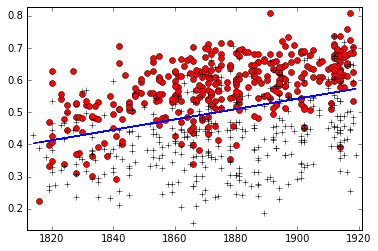

In [34]:
### DEFACTORING FUNCTION
### def diachronic_tilt(allvolumes, modeltype, datelimits):

### DEFACTORING FUNCTION PARAMETERS
modeltype = 'linear'
datelimits = []
''' Takes a set of predictions produced by a model that knows nothing about date,
and divides it along a line with a diachronic tilt. We need to do this in a way
that doesn't violate crossvalidation. I.e., we shouldn't "know" anything
that the model didn't know. We tried a couple of different ways to do this, but
the simplest and actually most reliable is to divide the whole dataset along a
linear central trend line for the data!
'''



listofrows = list()
classvector = list()

# DEPRECATED
# if modeltype == 'logistic' and len(datelimits) == 2:
#     # In this case we construct a subset of data to model on.
#     tomodeldata = list()
#     tomodelclasses = list()
#     pastthreshold, futurethreshold = datelimits

for volume in allvolumes:
    date = volume[3]
    logistic = volume[8]
    realclass = volume[13]
    listofrows.append([logistic, date])
    classvector.append(realclass)

    # DEPRECATED
    # if modeltype == 'logistic' and len(datelimits) == 2:
    #     if date >= pastthreshold and date <= futurethreshold:
    #         tomodeldata.append([logistic, date])
    #         tomodelclasses.append(realclass)

y, x = [a for a in zip(*listofrows)]
plt.axis([min(x) - 2, max(x) + 2, min(y) - 0.02, max(y) + 0.02])
reviewedx = list()
reviewedy = list()
randomx = list()
randomy = list()

for idx, reviewcode in enumerate(classvector):
    if reviewcode == 1:
        reviewedx.append(x[idx])
        reviewedy.append(y[idx])
    else:
        randomx.append(x[idx])
        randomy.append(y[idx])

plt.plot(reviewedx, reviewedy, 'ro')
plt.plot(randomx, randomy, 'k+')

if modeltype == 'logistic':
    # all this is DEPRECATED
    print("Hey, you're attempting to use the logistic-tilt option")
    print("that we deactivated. Go in and uncomment the code.")

    # if len(datelimits) == 2:
    #     data = pd.DataFrame(tomodeldata)
    #     responsevariable = tomodelclasses
    # else:
    #     data = pd.DataFrame(listofrows)
    #     responsevariable = classvector

    # newmodel = LogisticRegression(C = 100000)
    # newmodel.fit(data, responsevariable)
    # coefficients = newmodel.coef_[0]

    # intercept = newmodel.intercept_[0] / (-coefficients[0])
    # slope = coefficients[1] / (-coefficients[0])

    # p = np.poly1d([slope, intercept])

elif modeltype == 'linear':
    # what we actually do

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    slope = z[0]
    intercept = z[1]

plt.plot(x,p(x),"b-")
plt.show(block = False)

x = np.array(x, dtype='float64')
y = np.array(y, dtype='float64')
classvector = np.array(classvector)
dividingline = intercept + (x * slope)
predicted_as_reviewed = (y > dividingline)
really_reviewed = (classvector == 1)

accuracy = sum(predicted_as_reviewed == really_reviewed) / len(classvector)

### DEFACTORING FUNCTION RETURN
### return accuracy 

In [35]:
### DEFACTORING NAMESPACE
tiltaccuracy = accuracy 

In [36]:
### DEFACTORING FUNCTION CALL
### tiltaccuracy = diachronic_tilt(allvolumes, 'linear', []) 

print('If we divide the dataset with a horizontal line at 0.5, accuracy is: ', 
      str(rawaccuracy))

print("Divided with a line fit to the data trend, it's ", 
      str(tiltaccuracy))

If we divide the dataset with a horizontal line at 0.5, accuracy is:  0.775
Divided with a line fit to the data trend, it's  0.791666666667


## Conclusions

This notebook contains all of the code necessary to run through a full execution of the computational analysis.


Open questions for Underwood & Sellers:
- why does he normalize the word frequences (using `normalizearray()`) before modeling?
- Why does he normalize the coefficients ( divided by standard deviation)?

Basically, we don't have a firm understanding of why he is normalizing, mainly because we don't understand the meaning or significance of these steps on the interpretibility of the data. These are probably quite normal practices when performing logistic regression with these kinds of data, but there is a taken for granted quality to these actions that we'd like to see described as part of the methodology (or at least citations to a best practice).  

Full concluding remarks are in-progress.

## Bibliography ##

Frabetti, F., 2012. Have the Humanities Always Been Digital? In *Understanding Digital Humanities.* London; New York: Palgrave Macmillan, pp. 161–171.

Anderson, S., McPherson, T., 2011. Engaging Digital Scholarship: Thoughts on Evaluating Multimedia Scholarship. Profession 136–151.

Antonijevic, S., 2015. Amongst Digital Humanists: An ethnographic study of digital knowledge production, Palgrave Macmillan.

Baldridge, J., 2015. It’s okay for academic software to suck. Java Code Geeks. Available at: https://www.javacodegeeks.com/2015/05/its-okay-for-academic-software-to-suck.html [Accessed April 25, 2016].

Braithwaite, R., 2013. Defactoring. Reginald Braithwaite: via raganwald.com. Available at: http://raganwald.com/2013/10/08/defactoring.html [Accessed March 15, 2016].

Burgess, H.J. & Hamming, J., 2011. New Media in Academy: Labor and the Production of Knowledge in Scholarly Multimedia. DHQ: Digital Humanities Quarterly, 5(3). Available at: http://digitalhumanities.org/dhq/vol/5/3/000102/000102.html [Accessed September 2, 2016].

Clement, T.E., 2016. Where Is Methodology in Digital Humanities? In Debates in the Digital Humanities 2016. University of Minnesota Press, pp. 153–175. Available at: http://dhdebates.gc.cuny.edu/debates/text/65.

Enderle, J.S., 2016. A Plot of Brownian Noise. Jonathan Scott Enderle. Available at: https://github.com/senderle/svd-noise/blob/master/Noise.ipynb [Accessed September 24, 2016].

Ford, P., 2015. What is Code? Businessweek. Available at: http://www.bloomberg.com/graphics/2015-paul-ford-what-is-code/.

Grusin, R., 1994. What is an Electronic Author? Theory and the Technological Fallacy. Configurations, 2(3), pp.469–483.

Hiller, M., 2015. Signs o’ the Times: The Software of Philology and a Philology of Software. Digital Culture and Society, 1(1), pp.152–163.

Jockers, M.L., 2013. Macroanalysis: Digital Methods and Literary History, Urabana, Chicago, Springfield: UI Press.

Kittler, F., 1993. Es gibt keine Software. In Draculas Vermächtmis. Leipzig: Reclam Verlag, pp. 225–242.

Knuth, D.E., 1984. Literate Programming. The Computer Journal, 27(1), pp.97–111.

Latour, B., 1993. We Have Never Been Modern, Cambridge, Massachusetts: Harvard University Press.

Marino, M.C., 2006. Critical Code Studies. Electronic Book Review. Available at: http://www.electronicbookreview.com/thread/electropoetics/codology [Accessed January 16, 2015].

Nowviskie, B., 2011. Where Credit Is Due: Preconditions for the Evaluation of Collaborative Digital Scholarship. Profession, pp.169–181.

Piper, A., 2015. Novel Devotions: Conversional Reading, Computational Modeling, and the Modern Novel. New Literary History, 46(1), pp.63–98.

Presner, T., 2012. How to Evaluate Digital Scholarship. Journal of Digital Humanities, 1(4). Available at: http://journalofdigitalhumanities.org/1-4/how-to-evaluate-digital-scholarship-by-todd-presner/.

Purdy, J.P. & Walker, J.R., 2010. Valuing Digital Scholarship: Exploring the Changing Realities of Intellectual Work. Profession, pp.177–195.

Rockwell, G., 2011. On the Evaluation of Digital Media as Scholarship. Profession, pp.152–168.

Rybicki, J., Hoover, D. & Kestemont, M., 2014. Collaborative authorship: Conrad, Ford and Rolling Delta. Literary and Linguistic Computing, 29(3), pp.422–431.

Sahle, P. & Vogeler, G., 2014. Criteria for Reviewing Scholarly Digital Editions (version 1.1). Institut für Dokumentologie und Editorik. Available at: http://www.i-d-e.de/publikationen/weitereschriften/criteria-version-1-1/ [Accessed October 13, 2016].

Smithies, J., 2012. Evaluating Scholarly Digital Outputs: The Six Layers Approach. Journal of Digital Humanities, 1(4). Available at: http://journalofdigitalhumanities.org/1-4/evaluating-scholarly-digital-outputs-by-james-smithies/ [Accessed September 2, 2016].

Underwood, T., 2014. Understanding Genre in a Collection of a Million Volumes, Interim Report. Figshare. Available at: https://figshare.com/articles/Understanding_Genre_in_a_Collection_of_a_Million_Volumes_Interim_Report/1281251 [Accessed March 15, 2016].

Underwood, T. & Sellers, J., 2016. The Longue Durée of Literary Prestige. Modern Language Quarterly, 77(3), pp.321–344.

Vee, A., 2013. Understanding Computer Programming as a Literacy. LiCS, 1(2), pp.42–64.

Zundert, J.J. van, 2016. Author, Editor, Engineer — Code & the Rewriting of Authorship in Scholarly Editing. Interdisciplinary Science Reviews, 40(4), pp.349–375.